# Machine Learning Model for Spotify Playlist Prediction

### Import Libraries

In [364]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import spotipy
import os
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd

# Build the dataset we need

To build our dataset, we need a tagged dataset of songs. The tags are aggragated into a "score" to serve as a label. To get features for these songs, we need to search for the songs using the spotify api and build a full dataset with features and labels.

The features we are interested to find on spotify are as follows (obtained from the Spotify Webpage):

**Acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.


**Danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.


**Energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.


**Instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.


**Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides a strong likelihood that the track is live.
Loudness: the overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing the relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.


**Speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audiobook, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.


**Valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).


**Tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, the tempo is the speed or pace of a given piece and derives directly from the average beat duration.

In [321]:
# Authentication with Spotify
client_id = # Put your spotify_id here
client_secret = # Put your spotify secret here
client_url = # Put your spotify url here.

sp = spotipy.Spotify(
        auth_manager=SpotifyOAuth(
            scope="playlist-modify-private",
            redirect_uri=client_url,
            client_id=client_id,
            client_secret=client_secret,
            show_dialog=True,
            cache_path="token.txt"
        )
    )

In [322]:
# dataset obtained from https://gaurav22verma.github.io/IMAC_Dataset.html
imac_dataset = pd.read_csv('SongEmotionScore.csv', header=None)
imac_dataset.columns = ['track_id', 'track_name', 'artist_name', 'scores']
imac_dataset['scores'] = imac_dataset['scores'].str.split("_")
imac_dataset[['pos_score', 'neu_score', 'neg_score']] = pd.DataFrame(imac_dataset['scores'].to_list(), index=imac_dataset.index)
imac_dataset = imac_dataset.drop('scores', axis=1)

In [323]:
def find_track_id(t_name, a_name):
    track = sp.search(q=f"track:{t_name} artist:{a_name}", type="track")
    if len(track['tracks']['items']) == 0:
        return None
    else:
        track_id = track['tracks']['items'][0]['id']
        return track_id

In [324]:
imac_dataset['id'] = None
for index, row in imac_dataset.iterrows():
    imac_dataset.iloc[index, 6] = find_track_id(row['track_name'], row['artist_name'])

In [325]:
# insignificant amount of null values so they were removed
imac_dataset_clean = imac_dataset.loc[~imac_dataset['id'].isnull()]

In [326]:
features_data = []
for index, row in imac_dataset_clean.iterrows():
    features = sp.audio_features(row['id'])[0]
    features_data = features_data+[features]
    
new_fd = [data for data in features_data if data is not None]
second_half = pd.DataFrame(new_fd)
final_dataset = imac_dataset_clean.merge(second_half, how='inner', on='id')
final_final_dataset = final_dataset.drop_duplicates(subset=['id','track_name'])

In [328]:
# music_dataset is our complete dataset, ready to be used in our machine learning model
music_dataset = final_final_dataset

In [329]:
music_dataset.head()

,track_id,track_name,artist_name,pos_score,neu_score,neg_score,id,danceability,energy,key,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,TRAAAJN128F428E437,Welcome To The Pleasuredome,Frankie Goes To Hollywood,1,0,0,6PF0WYSCH6OhGKHRHOQSxG,0.665,0.462,11,...,0.015700,0.6490,0.518,113.205,audio_features,spotify:track:6PF0WYSCH6OhGKHRHOQSxG,https://api.spotify.com/v1/tracks/6PF0WYSCH6Oh...,https://api.spotify.com/v1/audio-analysis/6PF0...,820907,4
1,TRAAAJO12903CAAC69,Stranger in Paradise,Tony Bennett,0,1,0,1HUc5mDTIx8Ul2cxSiAkcj,0.283,0.326,5,...,0.000009,0.2190,0.108,79.176,audio_features,spotify:track:1HUc5mDTIx8Ul2cxSiAkcj,https://api.spotify.com/v1/tracks/1HUc5mDTIx8U...,https://api.spotify.com/v1/audio-analysis/1HUc...,300333,4
5,TRAAAZF12903CCCF6B,Break My Stride,Matthew Wilder,2,0,0,1mCsF9Tw4AkIZOjvZbZZdT,0.917,0.588,10,...,0.000000,0.0914,0.828,110.077,audio_features,spotify:track:1mCsF9Tw4AkIZOjvZbZZdT,https://api.spotify.com/v1/tracks/1mCsF9Tw4AkI...,https://api.spotify.com/v1/audio-analysis/1mCs...,184480,4
6,TRAAAGR128F425B14B,Into The Nightlife,Cyndi Lauper,1,0,0,4wDezvrA2mv0JTSHkLwOTW,0.636,0.540,9,...,0.000300,0.2030,0.674,124.002,audio_features,spotify:track:4wDezvrA2mv0JTSHkLwOTW,https://api.spotify.com/v1/tracks/4wDezvrA2mv0...,https://api.spotify.com/v1/audio-analysis/4wDe...,240640,4
7,TRAAAED128E0783FAB,It's About Time,Jamie Cullum,0,2,0,79AtmE4M8aPPYt5v03atAp,0.565,0.506,9,...,0.000069,0.1290,0.476,152.445,audio_features,spotify:track:79AtmE4M8aPPYt5v03atAp,https://api.spotify.com/v1/tracks/79AtmE4M8aPP...,https://api.spotify.com/v1/audio-analysis/79At...,247000,4


In [330]:
# choose only numerical features of model
numerical_features = ['danceability', 
                      'energy', 
                      'key', 
                      'loudness', 
                      'mode', 
                      'speechiness', 
                      'acousticness', 
                      'instrumentalness', 
                      'liveness', 
                      'valence', 
                      'tempo',
                      'time_signature'
                     ]

# Split into test-train data

In [331]:
df_train, df_test = train_test_split(music_dataset, random_state=42, test_size=0.25)

In [332]:
# we need to create different y arrays for each target (Pos, Neu, Neg), we will train models for the 3 separately
X_train = df_train[numerical_features]
y_train_pos = df_train['pos_score']
y_train_neu = df_train['neu_score']
y_train_neg = df_train['neg_score']

X_test = df_test[numerical_features]
y_test_pos = df_test['pos_score']
y_test_neu = df_test['neu_score']
y_test_neg = df_test['neg_score']

In [333]:
# select features that need to be normalized
features_to_be_scaled = ['tempo', 'time_signature']

In [334]:
# to normalize some columns
ct = ColumnTransformer(
    [
        ('scale', StandardScaler(), features_to_be_scaled)
    ]
)
features_scaled = ct.fit_transform(X_train)

In [335]:
X_train.loc[:, features_to_be_scaled] = features_scaled

/Applications/anaconda3/envs/mfp_env/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


# Perform Training and Choose between models

We trained 3 models (KNN, Random Forest, Neural Net) and performed Grid Search to tune hyperparameters. (Other models are omitted for simplicity)

We chose to train 3 Random Forests for each of Positive, Neutral and Negative labels. 

In [336]:
forest = RandomForestClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=100)
forest.fit(X_train,y_train_pos)

y_pred_train_pos_rf = forest.predict(X_train) 
print("Pos Train Accuracy: ", accuracy_score(y_train_pos, y_pred_train_pos_rf))

y_pred_test_pos_rf = forest.predict(X_test)
print("Pos Test Accuracy: ", accuracy_score(y_test_pos, y_pred_test_pos_rf))

Pos Train Accuracy:  0.8070240295748614
Pos Test Accuracy:  0.7017738359201774


In [337]:
forest2 = RandomForestClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=15, n_estimators=300)
forest2.fit(X_train,y_train_neu)

y_pred_train_neu_rf = forest2.predict(X_train) 
print("Neu Train Accuracy: ", accuracy_score(y_train_neu, y_pred_train_neu_rf))

y_pred_test_neu_rf = forest2.predict(X_test)
print("Neu Test Accuracy: ", accuracy_score(y_test_neu, y_pred_test_neu_rf))

Neu Train Accuracy:  0.6147874306839187
Neu Test Accuracy:  0.5709534368070953


In [338]:
forest3 = RandomForestClassifier(max_depth=25, min_samples_leaf=2, min_samples_split=100, n_estimators=100)
forest3.fit(X_train,y_train_neg)

y_pred_train_neg_rf = forest3.predict(X_train) 
print("Neg Train Accuracy: ", accuracy_score(y_train_neg, y_pred_train_neg_rf))

y_pred_test_neg_rf = forest3.predict(X_test)
print("Neg Test Accuracy: ", accuracy_score(y_test_neg, y_pred_test_neg_rf))

Neg Train Accuracy:  0.7038817005545287
Neg Test Accuracy:  0.6541019955654102


# Pull playlists from my spotify

In [339]:
playlists = sp.user_playlists(user_id, limit=50)

In [340]:
playlist_ids = [playlist['id'] for playlist in playlists['items']]

In [369]:
def find_features_for_playlist(playlist_id):
    '''
    Arguments: spotify playlist_id
    
    Returns: dataframe with features for a certain play_list
    '''
    tracks = [track['track']['id'] for track in sp.playlist_tracks(playlist_id)['items']]
    features_tracks = []
    for id_ in tracks:
        features = sp.audio_features(id_)[0]
        features_tracks = features_tracks+[features]
    playlist_features = pd.DataFrame(features_tracks)
    return playlist_features[numerical_features]

def find_predictions_for_playlist(df):
    '''
    Arguments: a dataframe containing features of a playlist
    
    Returns: dataframe containing predictions for each song for each label
    '''
    y_pred_test_pos_new = forest.predict(df)
    y_pred_test_neu_new = forest2.predict(df)
    y_pred_test_neg_new = forest3.predict(df)
    results = pd.DataFrame(np.array([y_pred_test_pos_new, y_pred_test_neu_new, y_pred_test_neg_new])).T
    results.columns = ['pos_score', 'neu_score', 'neg_score']
    return results

def plot_graph_1(results):
    '''
    Arguments: dataframe with predictions for each song for each label
    
    Returns: barchart to show average scores for each label for a playlist
    '''
    results_clean = pd.DataFrame(results.stack()).reset_index().rename({'level_0':'track', 'level_1':'type', 0:'score'}, axis=1)
    results_clean['score'] = results_clean['score'].astype(int)
    return sns.barplot(x='type', y='score', data=results_clean, ci=None, palette='RdYlBu')
    
def predict_and_plot(playlist_id):
    data = find_features_for_playlist(playlist_id)
    predictions = find_predictions_for_playlist(data)
    return plot_graph_1(predictions)

# Trial on sample playlist

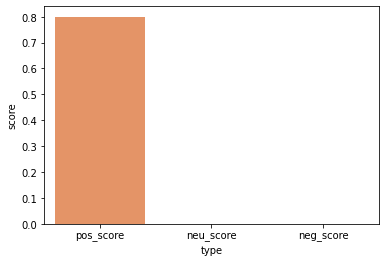

In [370]:
# pop playlist
pop_graph = predict_and_plot(playlist_ids[4])
pop_graph.figure.savefig('graphs/pop_graph.png')

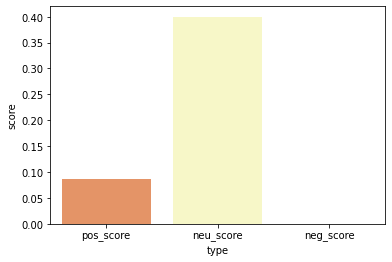

In [371]:
# mood playlist 
mood_graph = predict_and_plot(playlist_ids[3])
mood_graph.figure.savefig('graphs/mood_graph.png')

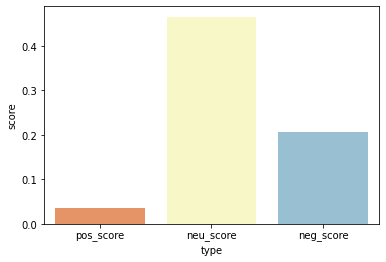

In [372]:
# slow_paced playlist
slow_paced_graph = predict_and_plot(playlist_ids[8])
slow_paced_graph.figure.savefig('graphs/slow_paced_graph.png')